<a href="https://www.kaggle.com/code/jeremyhaakenson/crab-xgboost?scriptVersionId=285333186" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

#EDA

**Load packages.**

In [1]:
library(skimr)
library(moments)
library(dplyr)
library(caret)
library(xgboost)


Attaching package: ‘dplyr’


The following objects are masked from ‘package:stats’:

    filter, lag


The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Loading required package: ggplot2

Loading required package: lattice


Attaching package: ‘caret’


The following object is masked from ‘package:httr’:

    progress



Attaching package: ‘xgboost’


The following object is masked from ‘package:dplyr’:

    slice




**Load data.**

In [2]:
train = read.csv('/kaggle/input/playground-series-s3e16/train.csv')
test = read.csv('/kaggle/input/playground-series-s3e16/test.csv')

**Examine data.**

In [3]:
any(is.na(train))
any(is.na(test))

[1] FALSE

[1] FALSE

**There are no missing values in train or test.**

**Convert Sex to categorical.**

In [4]:
train$Sex = as.factor(train$Sex)
test$Sex = as.factor(test$Sex)

#Feature Engineering

**I will add 3 new features: Shell.Percent, Meat.Percent, and Viscera.Percent.**

In [5]:
train.fe = train %>%
  mutate(Shell.Percent = Shell.Weight/Weight,
         Meat.Percent = Shucked.Weight/Weight,
         Viscera.Percent = Viscera.Weight/Weight)

test.fe = test %>%
    mutate(Shell.Percent = Shell.Weight/Weight,
          Meat.Percent = Shucked.Weight/Weight,
          Viscera.Percent = Viscera.Weight/Weight)

head(train.fe)

,id,Sex,Length,Diameter,Height,Weight,Shucked.Weight,Viscera.Weight,Shell.Weight,Age,Shell.Percent,Meat.Percent,Viscera.Percent
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0,I,1.5250,1.1750,0.3750,28.97319,12.728926,6.647958,8.348928,9,0.2881605,0.4393346,0.2294521
2,1,I,1.1000,0.8250,0.2750,10.41844,4.521745,2.324659,3.401940,8,0.3265306,0.4340136,0.2231293
3,2,M,1.3875,1.1125,0.3750,24.77746,11.339800,5.556502,6.662133,9,0.2688787,0.4576659,0.2242563
4,3,F,1.7000,1.4125,0.5000,50.66056,20.354941,10.991839,14.996885,11,0.2960269,0.4017907,0.2169703
5,4,I,1.2500,1.0125,0.3375,23.28911,11.977664,4.507570,5.953395,8,0.2556299,0.5143031,0.1935484
6,5,M,1.5000,1.1750,0.4125,28.84562,13.409313,6.789705,7.937860,10,0.2751843,0.4648649,0.2353808


#Correlation

**Look for correlation between variables.**

In [6]:
cor(train.fe[3:13], method = 'spearman')

,Length,Diameter,Height,Weight,Shucked.Weight,Viscera.Weight,Shell.Weight,Age,Shell.Percent,Meat.Percent,Viscera.Percent
Length,1.00000000,0.98394293,0.908566127,0.976708090,0.96017164,0.95815094,0.953545164,0.668712061,-0.24645745,0.093872882,0.016969047
Diameter,0.98394293,1.00000000,0.912796255,0.976879525,0.95622391,0.95722974,0.958793115,0.678573500,-0.22870583,0.077617472,0.012382236
Height,0.90856613,0.91279626,1.000000000,0.926750150,0.89072234,0.91075326,0.930749648,0.704477606,-0.14871579,0.006959979,0.019731057
Weight,0.97670809,0.97687952,0.926750150,1.000000000,0.97543504,0.97516738,0.971981870,0.689562366,-0.26871179,0.071433199,-0.003093649
Shucked.Weight,0.96017164,0.95622391,0.890722340,0.975435037,1.00000000,0.95008090,0.926190368,0.612695724,-0.34305384,0.254799238,-0.011182225
Viscera.Weight,0.95815094,0.95722974,0.910753257,0.975167376,0.95008090,1.00000000,0.946806919,0.676960216,-0.26731782,0.059579471,0.181770610
Shell.Weight,0.95354516,0.95879311,0.930749648,0.971981870,0.92619037,0.94680692,1.000000000,0.736481013,-0.07306613,-0.018817547,-0.008214282
Age,0.66871206,0.67857350,0.704477606,0.689562366,0.61269572,0.67696022,0.736481013,1.000000000,0.05318348,-0.214272506,0.003205292
Shell.Percent,-0.24645745,-0.22870583,-0.148715786,-0.268711794,-0.34305384,-0.26731782,-0.073066131,0.053183481,1.00000000,-0.357719114,0.029330135
Meat.Percent,0.09387288,0.07761747,0.006959979,0.071433199,0.25479924,0.05957947,-0.018817547,-0.214272506,-0.35771911,1.000000000,-0.037396327


**Length, Diameter, Height, Weight, Shucked.Weight, Viscera.Weight, and Shell.Weight are all highly correlated with each other.**

**I will keep Shell.Weight since it has the highest correlation with Age out of those 7 variables.**

**None of the variables in train are highly correlated with Age (rho >= .75).**

In [7]:
train.cor = train.fe[c(1:2, 9:13)]
head(train.cor)

test.cor = test.fe[c(1:2, 9, 10:12)]
head(test.cor)

,id,Sex,Shell.Weight,Age,Shell.Percent,Meat.Percent,Viscera.Percent
,<int>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0,I,8.348928,9,0.2881605,0.4393346,0.2294521
2,1,I,3.401940,8,0.3265306,0.4340136,0.2231293
3,2,M,6.662133,9,0.2688787,0.4576659,0.2242563
4,3,F,14.996885,11,0.2960269,0.4017907,0.2169703
5,4,I,5.953395,8,0.2556299,0.5143031,0.1935484
6,5,M,7.937860,10,0.2751843,0.4648649,0.2353808


,id,Sex,Shell.Weight,Shell.Percent,Meat.Percent,Viscera.Percent
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,74051,I,2.721552,0.3157895,0.4243421,0.2006579
2,74052,I,3.968930,0.2559415,0.4533821,0.2093236
3,74053,F,4.819415,0.3307393,0.3813230,0.2665370
4,74054,F,7.030676,0.2477522,0.4715285,0.2307692
5,74055,I,3.331066,0.2831325,0.4698795,0.2096386
6,74056,M,8.079607,0.3253425,0.3515982,0.2300228


#Skew

**Look for skew one variable at a time.**

**Shell.Weight**

In [8]:
skewness(train.cor$Shell.Weight)

[1] 0.2774533

**Shell.Percent**

In [9]:
skewness(train.cor$Shell.Percent)
skewness(sqrt(train.cor$Shell.Percent))

[1] 3.968872

[1] 1.097717

In [10]:
train.cor$Shell.Percent = sqrt(train.cor$Shell.Percent)
test.cor$Shell.Percent = sqrt(test.cor$Shell.Percent)

**Meat.Percent**

In [11]:
skewness(train.cor$Meat.Percent)
skewness(sqrt(train.cor$Meat.Percent))
skewness((train.cor$Meat.Percent)^(1/3))
skewness(log(train.cor$Meat.Percent))

[1] 28.13927

[1] 6.746362

[1] 3.706098

[1] 0.7869806

In [12]:
train.cor$Meat.Percent = log(train.cor$Meat.Percent)
test.cor$Meat.Percent = log(test.cor$Meat.Percent)

**Viscera.Percent**

In [13]:
skewness(train.cor$Viscera.Percent)

[1] 1.723014

#Outliers

**Define a function for replacing outliers.**

In [14]:
outlier_norm <- function(x){
  qntile <- quantile(x, probs=c(.25, .75))
  H <- 1.5 * IQR(x)
  x[x < median(x) - H] <- median(x) - H
  x[x > median(x) + H] <- median(x) + H
  return(x)
}

**Look for outliers.**

In [15]:
head(train.cor)

,id,Sex,Shell.Weight,Age,Shell.Percent,Meat.Percent,Viscera.Percent
,<int>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0,I,8.348928,9,0.5368058,-0.8224939,0.2294521
2,1,I,3.401940,8,0.5714286,-0.8346794,0.2231293
3,2,M,6.662133,9,0.5185352,-0.7816158,0.2242563
4,3,F,14.996885,11,0.5440835,-0.9118239,0.2169703
5,4,I,5.953395,8,0.5055986,-0.6649425,0.1935484
6,5,M,7.937860,10,0.5245801,-0.7660085,0.2353808


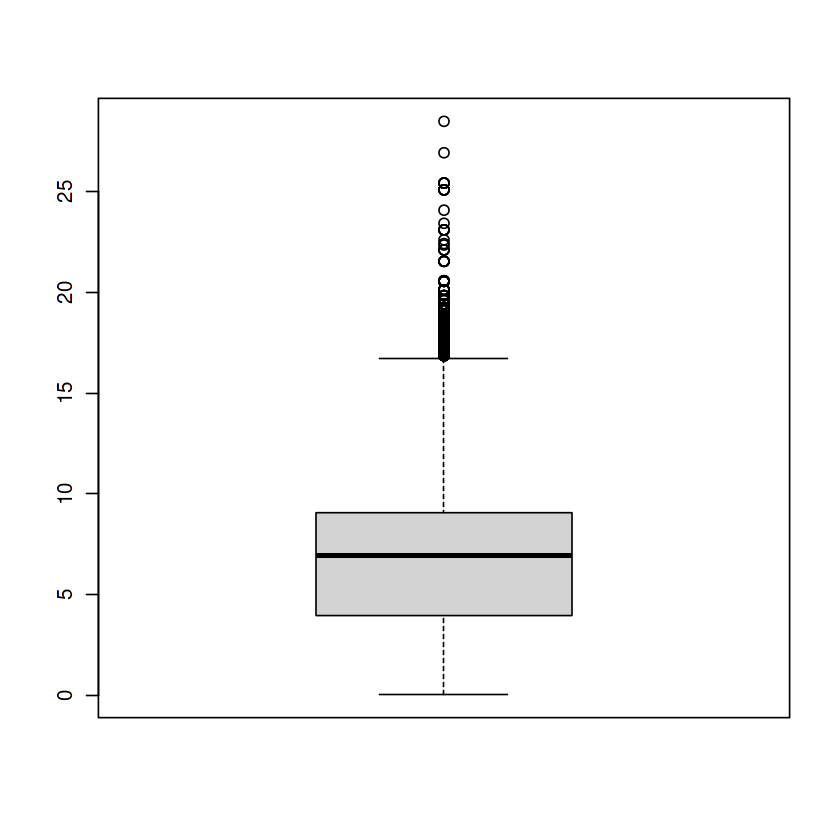

In [16]:
boxplot(train.cor$Shell.Weight)

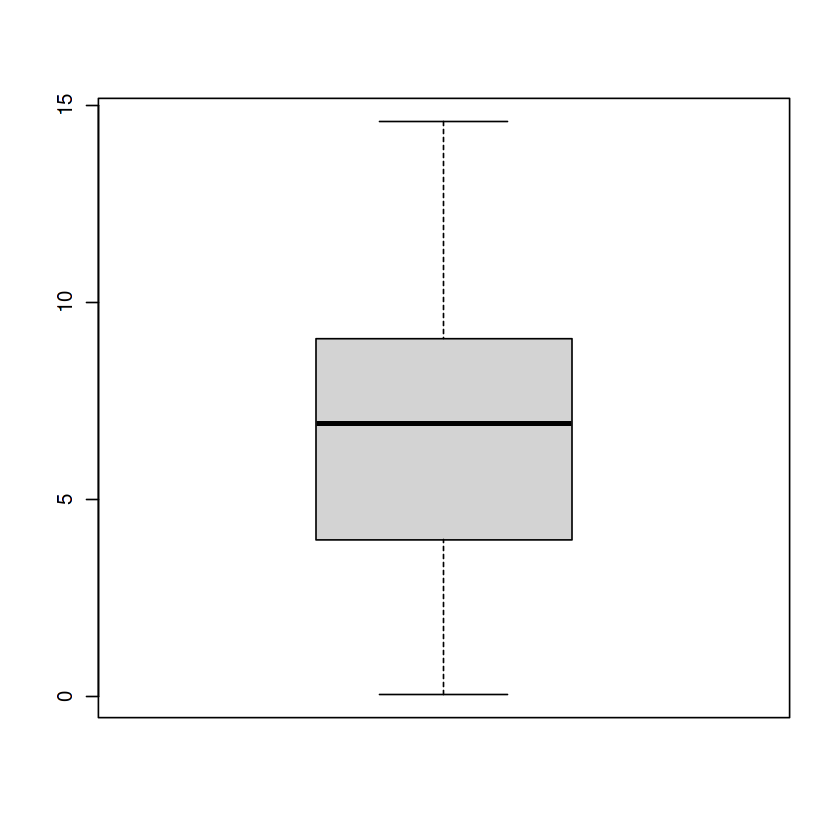

In [17]:
train.out = train.cor %>%
    mutate(Shell.Weight = outlier_norm(Shell.Weight))

test.out = test.cor %>%
    mutate(Shell.Weight = outlier_norm(Shell.Weight))

boxplot(train.out$Shell.Weight)

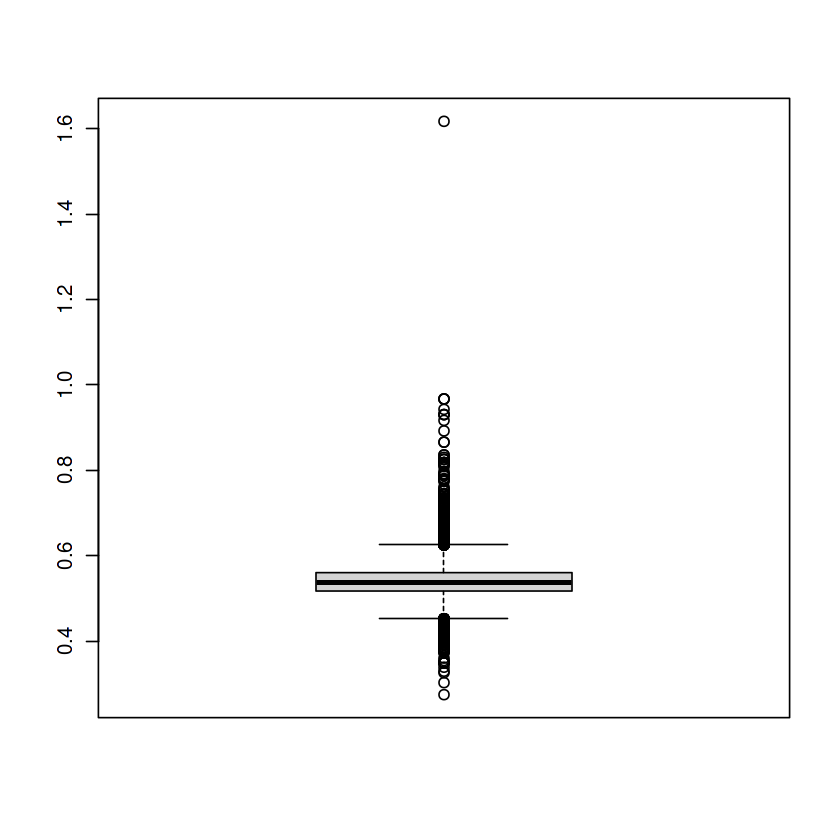

In [18]:
boxplot(train.out$Shell.Percent)

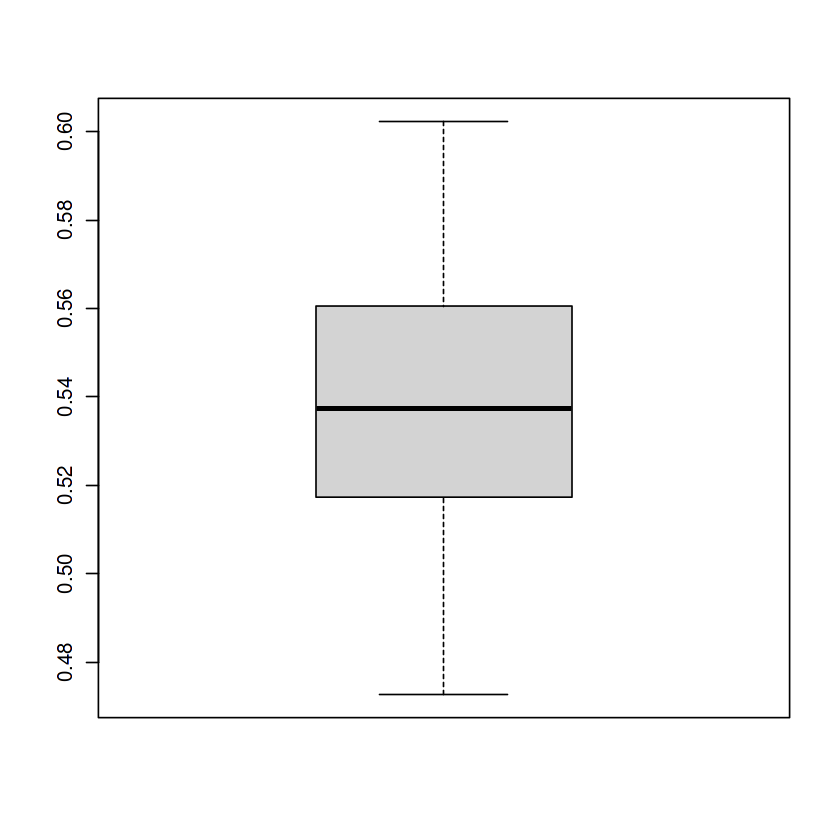

In [19]:
train.out$Shell.Percent = outlier_norm(train.out$Shell.Percent)

test.out$Shell.Percent = outlier_norm(test.out$Shell.Percent)

boxplot(train.out$Shell.Percent)

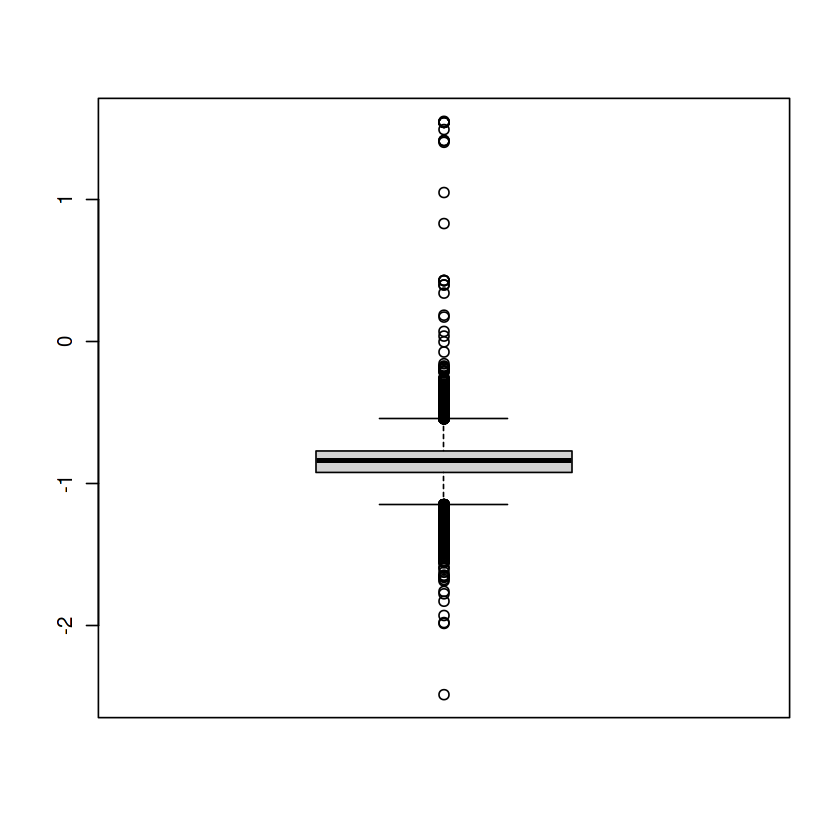

In [20]:
boxplot(train.out$Meat.Percent)

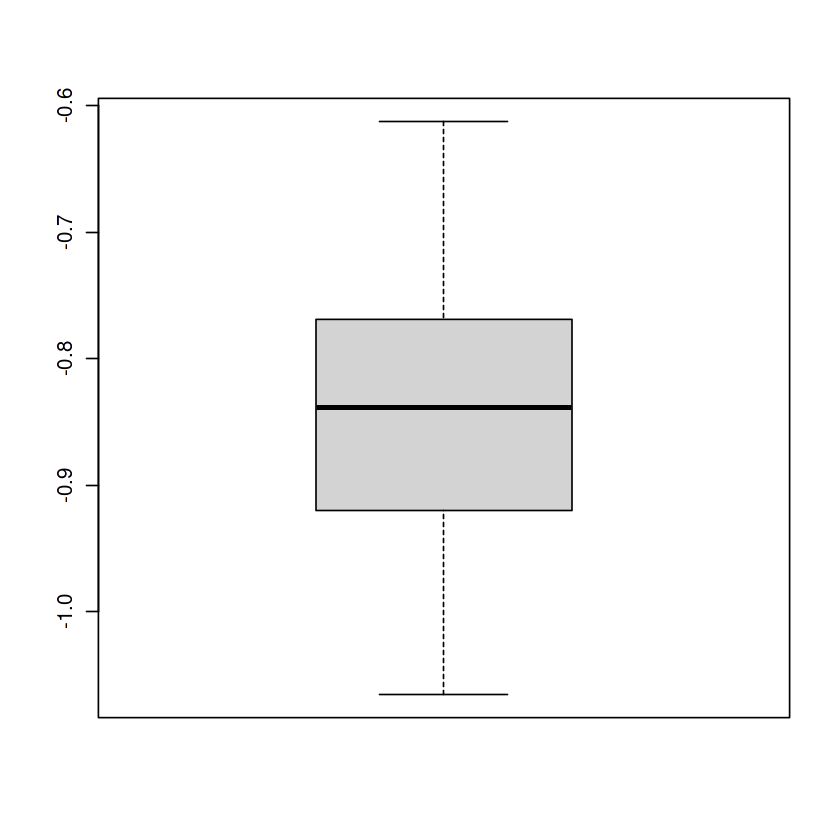

In [21]:
train.out$Meat.Percent = outlier_norm(train.out$Meat.Percent)

test.out$Meat.Percent = outlier_norm(test.out$Meat.Percent)

boxplot(train.out$Meat.Percent)

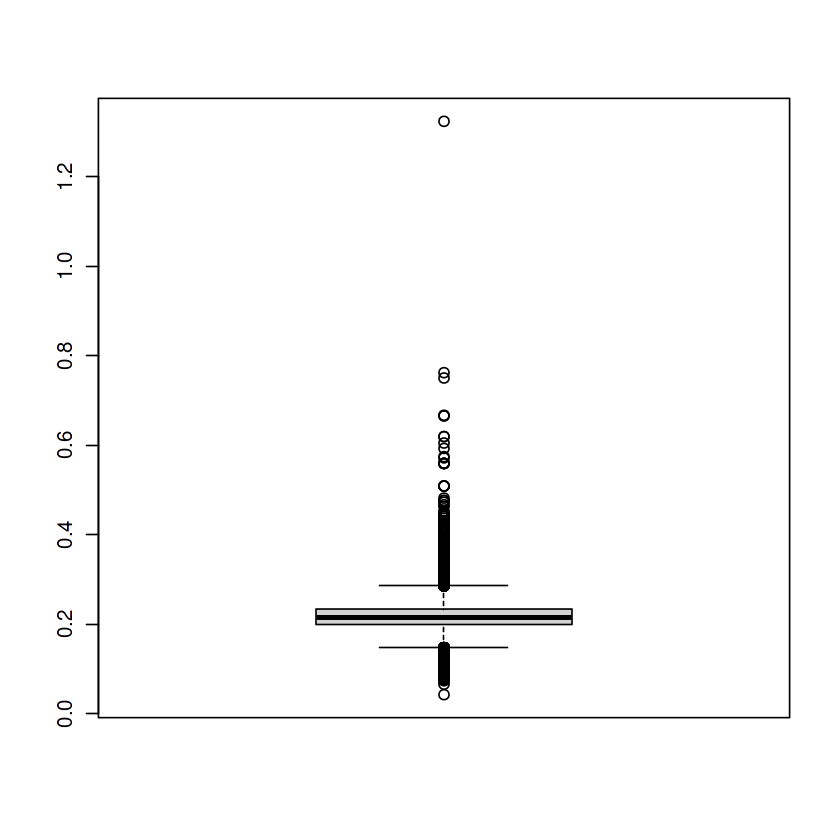

In [22]:
boxplot(train.out$Viscera.Percent)

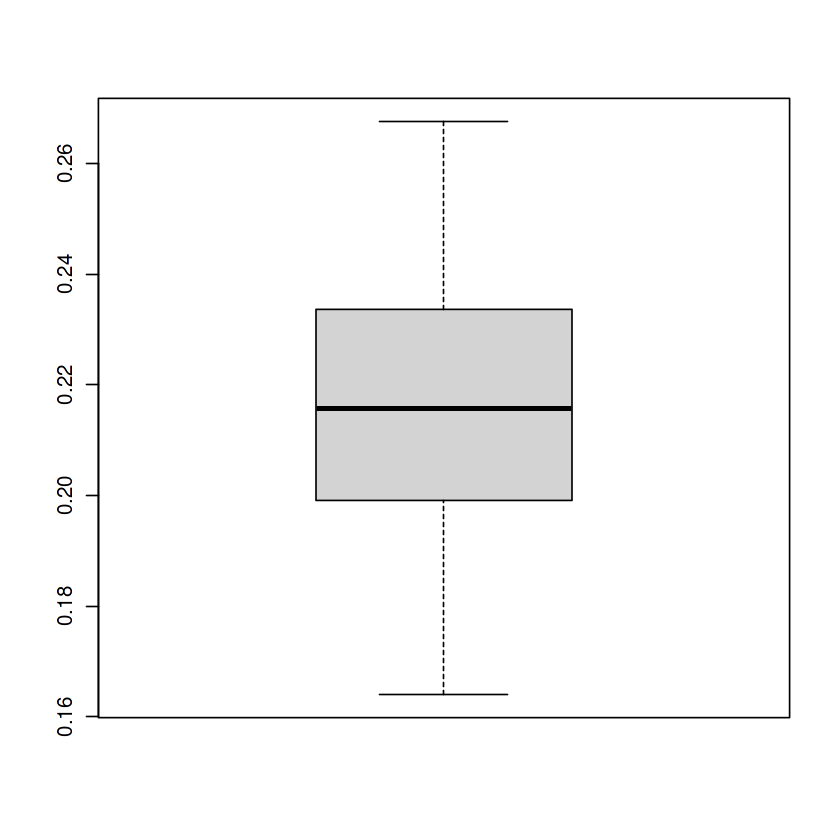

In [23]:
train.out$Viscera.Percent = outlier_norm(train.out$Viscera.Percent)

test.out$Viscera.Percent = outlier_norm(test.out$Viscera.Percent)

boxplot(train.out$Viscera.Percent)

#Scaling

In [24]:
head(train.out)
head(test.out)

,id,Sex,Shell.Weight,Age,Shell.Percent,Meat.Percent,Viscera.Percent
,<int>,<fct>,<dbl>,<int>,<dbl>,<dbl>,<dbl>
1,0,I,8.348928,9,0.5368058,-0.8224939,0.2294521
2,1,I,3.401940,8,0.5714286,-0.8346794,0.2231293
3,2,M,6.662133,9,0.5185352,-0.7816158,0.2242563
4,3,F,14.585818,11,0.5440835,-0.9118239,0.2169703
5,4,I,5.953395,8,0.5055986,-0.6649425,0.1935484
6,5,M,7.937860,10,0.5245801,-0.7660085,0.2353808


,id,Sex,Shell.Weight,Shell.Percent,Meat.Percent,Viscera.Percent
,<int>,<fct>,<dbl>,<dbl>,<dbl>,<dbl>
1,74051,I,2.721552,0.5619515,-0.8572153,0.2006579
2,74052,I,3.968930,0.5059066,-0.7910201,0.2093236
3,74053,F,4.819415,0.5750994,-0.9641086,0.2665370
4,74054,F,7.030676,0.4977472,-0.7517758,0.2307692
5,74055,I,3.331066,0.5321020,-0.7552790,0.2096386
6,74056,M,8.079607,0.5703880,-1.0452663,0.2300228


In [25]:
train.sca = scale(train.out[c(3, 5:7)])
train.scale = cbind.data.frame(train.out[1:2], train.sca, train.out[4])

test.sca = scale(test.out[3:6])
test.scale = cbind.data.frame(test[1:2], test.sca)

#One-hot Encoding

In [26]:
hot1 = dummyVars('~ .', data = train.scale)
train.hot = data.frame(predict(hot1, newdata = train.scale))

hot2 = dummyVars('~ .', data = test.scale)
test.hot = data.frame(predict(hot2, newdata = test.scale))

head(train.hot)
head(test.hot)

,id,Sex.F,Sex.I,Sex.M,Shell.Weight,Shell.Percent,Meat.Percent,Viscera.Percent,Age
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,0,0,1,0,0.473452366,-0.07882564,0.2210556,0.51102978,9
2,1,0,1,0,-0.940597781,1.02610615,0.1097798,0.26353102,8
3,2,0,0,1,-0.008702269,-0.66190456,0.5943460,0.30764774,9
4,3,1,0,0,2.256208997,0.15343092,-0.5946891,0.02244785,11
5,4,0,1,0,-0.211288250,-1.07475493,1.6597841,-0.89437749,8
6,5,0,0,1,0.355952497,-0.46899009,0.7368688,0.74310500,10


,id,Sex.F,Sex.I,Sex.M,Shell.Weight,Shell.Percent,Meat.Percent,Viscera.Percent
,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
1,74051,0,1,0,-1.14357175,0.7227927,-0.08867063,-0.6113890
2,74052,0,1,0,-0.78650187,-1.0622529,0.51454487,-0.2709705
3,74053,1,0,0,-0.54304513,1.1415570,-1.06275426,1.9765707
4,74054,1,0,0,0.08994238,-1.3221334,0.87216495,0.5714894
5,74055,0,1,0,-0.96909443,-0.2279224,0.84024173,-0.2585973
6,74056,0,0,1,0.39020569,0.9914980,-1.80231776,0.5421682


#XGBoost Model

**Put data in XGBoost format.**

In [27]:
train.xgb <- xgb.DMatrix(label = train.hot$Age, data = as.matrix(train.hot[2:8]))
test.xgb = as.matrix(test.hot[2:8])

**Determine number of rounds to use after optimizing parameters (not shown).**

In [28]:
set.seed(155)
xgb3 = xgb.cv(params = list(eta = .3, 
                            gamma = 0,
                            subsample = .8,
                            colsample_bytree = .9, 
                            reg_alpha = .08,
                            reg_lambda = 1),
              max_depth = 3,
              min_child_weight = 16,
              data = train.xgb, 
              nrounds = 400,
              objective = 'reg:absoluteerror',
              nfold = 10, 
              early_stopping_rounds = 16)

[1]	train-mae:2.227586+0.010460	test-mae:2.227674+0.028890 
Multiple eval metrics are present. Will use test_mae for early stopping.
Will train until test_mae hasn't improved in 16 rounds.

[2]	train-mae:2.139067+0.008646	test-mae:2.139432+0.027863 
[3]	train-mae:2.052670+0.014116	test-mae:2.053258+0.028952 
[4]	train-mae:1.965802+0.013451	test-mae:1.966430+0.024742 
[5]	train-mae:1.894725+0.014920	test-mae:1.895596+0.024869 
[6]	train-mae:1.825864+0.014472	test-mae:1.826756+0.028492 
[7]	train-mae:1.761457+0.016662	test-mae:1.762185+0.032443 
[8]	train-mae:1.704003+0.019350	test-mae:1.704856+0.036281 
[9]	train-mae:1.656873+0.018296	test-mae:1.658232+0.034101 
[10]	train-mae:1.614026+0.015483	test-mae:1.615800+0.031623 
[11]	train-mae:1.575337+0.014965	test-mae:1.577368+0.032466 
[12]	train-mae:1.546177+0.013044	test-mae:1.548481+0.031638 
[13]	train-mae:1.520246+0.010164	test-mae:1.522775+0.027854 
[14]	train-mae:1.501707+0.007931	test-mae:1.504420+0.025685 
[15]	train-mae:1.486678+0

**Use 261 rounds.**

In [29]:
set.seed(155)
xgb4 = xgboost(params = list(eta = .3, 
                            gamma = 0,
                            subsample = .8,
                            colsample_bytree = .9, 
                            reg_alpha = .08,
                            reg_lambda = 1),
              max_depth = 3,
              min_child_weight = 16,
              data = train.xgb, 
              nrounds = 261,
              objective = 'reg:absoluteerror')


[1]	train-mae:2.224217 
[2]	train-mae:2.133178 
[3]	train-mae:2.058188 
[4]	train-mae:1.966525 
[5]	train-mae:1.890085 
[6]	train-mae:1.821229 
[7]	train-mae:1.757355 
[8]	train-mae:1.697608 
[9]	train-mae:1.647538 
[10]	train-mae:1.602516 
[11]	train-mae:1.562911 
[12]	train-mae:1.531956 
[13]	train-mae:1.510482 
[14]	train-mae:1.500075 
[15]	train-mae:1.492045 
[16]	train-mae:1.475694 
[17]	train-mae:1.462096 
[18]	train-mae:1.452926 
[19]	train-mae:1.443468 
[20]	train-mae:1.435148 
[21]	train-mae:1.429704 
[22]	train-mae:1.425044 
[23]	train-mae:1.421211 
[24]	train-mae:1.417648 
[25]	train-mae:1.414832 
[26]	train-mae:1.413066 
[27]	train-mae:1.409969 
[28]	train-mae:1.407814 
[29]	train-mae:1.405923 
[30]	train-mae:1.404213 
[31]	train-mae:1.402330 
[32]	train-mae:1.400999 
[33]	train-mae:1.400098 
[34]	train-mae:1.398768 
[35]	train-mae:1.397129 
[36]	train-mae:1.396172 
[37]	train-mae:1.394995 
[38]	train-mae:1.393692 
[39]	train-mae:1.392451 
[40]	train-mae:1.391474 
[41]	trai

**Plot variable importance.**

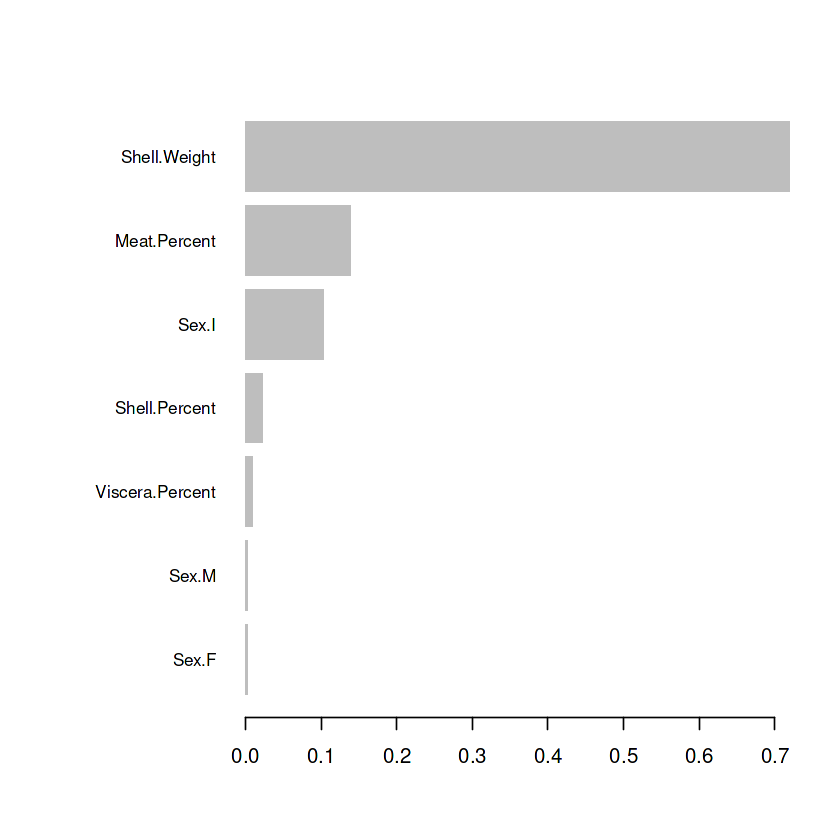

In [30]:
xgb4.imp = xgb.importance(colnames(train.xgb), model = xgb4)
xgb.plot.importance(xgb4.imp)

**Shell weight is by far the most important variable in this model.**

**Predict with xgb4.  It helps to round the predictions to the nearest integer.  (See the Discussion board for this competition for more info.)**

In [31]:
xgb4.age = round(predict(xgb4, test.xgb))
range(train$Age)
range(xgb4.age)

[1]  1 29

[1]  3 18

In [32]:
xgb4.guess = cbind.data.frame(test[1], xgb4.age)
colnames(xgb4.guess) = c('id', 'Age')
write.csv(xgb4.guess, 'submission.csv', row.names = F)